# 2. Моделирование при помощи kNN

Поскольку мы выбрали kNN для построения модели, то нам следует помнить, что этот алгоритм чувствителен к выбросам(которых у нас навалом), то есть к переобучению, и при большом количестве признаков его настигает проклятие размерности.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [16]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tasks/set.csv', index_col=False)
df.sample(7)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
403,0,12.940,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.023900,0.1735,...,13.860,23.02,89.69,580.9,0.1172,0.1958,0.18100,0.08388,0.3297,0.07834
494,0,13.160,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.012560,0.1713,...,14.500,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429
530,0,11.750,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.044400,0.1598,...,13.500,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757
59,0,8.618,11.79,54.34,224.5,0.09752,0.05272,0.02061,0.007799,0.1683,...,9.507,15.40,59.90,274.9,0.1733,0.1239,0.11680,0.04419,0.3220,0.09026
170,0,12.320,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.037000,0.1959,...,13.500,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
139,0,11.280,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.047960,0.1771,...,11.920,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
120,0,11.410,10.82,73.34,403.3,0.09373,0.06685,0.03512,0.026230,0.1667,...,12.820,15.97,83.74,510.5,0.1548,0.2390,0.21020,0.08958,0.3016,0.08523


2.2. Необходимо стандартизировать и нормализовать данные, чтобы привести признаки к одному масштабу (с нулевым матожиданием и единичной дисперсией в диапазоне от нуля до единицы) и избавиться от различия в измерениях. Этот прием способствует улучшению точности работы модели, уменьшению влияния выбросов и повышению скорости работы алгоритма.

In [17]:
min_max_scaler = MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df_norm.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1.0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1.0,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1.0,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1.0,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


2.1. Разобьем данные на train-test, отложив 30% для тестирования.

In [18]:
X = df_norm.drop(['diagnosis'], axis=1)
y = df_norm[['diagnosis']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df_norm['diagnosis'], random_state=1234)

Параметр stratify позволяет создавать такие разбиения, в которых распределения указанной переменной будут сохраняться. Это очень полезно при дисбалансе классов(наш случай), поскольку использование параметра stratify позволяет сохранить пропорции классов в обучающей и тестовой выборках, что повышает точность оценки качества модели.

2.3. Создаем классификатор без настройки параметров.

In [20]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
#knn.score(X_test, y_test)

2.4. Оценим метрики.

In [21]:
def quality(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test.squeeze(), y_pred.squeeze())
    tn, fp, fn, tp = metrics.confusion_matrix(y_test.squeeze(), y_pred.squeeze()).ravel()
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}\nROC-AUC:  {:.3f}".format(
        accuracy, precision, recall, f1, roc_auc
    ))
    print(f'Confusion Matrix = \n{cm}')
    print(f'True Negative: {tn}')
    print(f'False Positive: {fp}')
    print(f'False Negative: {fn}')
    print(f'True Positive: {tp}')


In [22]:
quality(y_pred, y_test)

Accuracy:  0.953
Precision: 0.938
Recall:    0.938
F1-score:  0.938
ROC-AUC:  0.950
Confusion Matrix = 
[[103   4]
 [  4  60]]
True Negative: 103
False Positive: 4
False Negative: 4
True Positive: 60


Похоже, что stratify сработал, как надо (спойлер: сначала разбила данные без него, но результат был таков, что recall - 1, да и иные не отставали, а это могло быть переобучением).

Попробуем поменять количество соседей.

In [23]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [24]:
quality(y_pred, y_test)

Accuracy:  0.977
Precision: 0.969
Recall:    0.969
F1-score:  0.969
ROC-AUC:  0.975
Confusion Matrix = 
[[105   2]
 [  2  62]]
True Negative: 105
False Positive: 2
False Negative: 2
True Positive: 62


Очень замечательно выходит.

Посмотрим, какое число соседей будет оптимальным, заодно проверим наши опасения насчет переобучения.

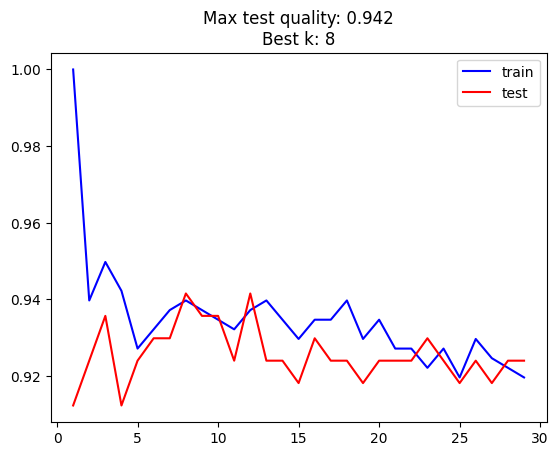

In [25]:
neighbors = range(1, 30)
accuracy_train = []
accuracy_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform',
                               algorithm='auto', leaf_size=30,
                               metric='cosine', metric_params=None,
                               n_jobs=4)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_train)
    preds_test = knn.predict(X_test)
    accuracy_train.append(metrics.accuracy_score(preds, y_train))
    accuracy_test.append(metrics.accuracy_score(preds_test, y_test))
    
plt.plot(neighbors, accuracy_train, color='blue', label='train')
plt.plot(neighbors, accuracy_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(np.amax(accuracy_test), np.argmax(accuracy_test)+1))
plt.legend()
plt.show()

Мы в шоке: стоило поменять метрику расстояния euclidean на cosine, как, понизив точность, модель стала лучше предсказывать результат!
Возможно потому, что оно учитывает угол между векторами, что позволяет более точно оценивать сходство между ними (у нас же там зависимости сплошные).

Философский вопрос о понижении точности:

это могло произойти, если модель была переобучена на обучающей выборке и имела высокую точность на ней, но плохо работала на новых данных. Понижение точности может означать, что модель стала более обобщающей и лучше работает на новых данных.В нашем случае, если было слишком мало соседей для устойчивой классификации, то понижение точности позволило увеличить количество соседей и сделать модель более устойчивой. 
Интернет говорит, что улучшение модели при понижении точности не является типичной ситуацией и требует дополнительного анализа.

In [26]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [27]:
quality(y_pred, y_test)

Accuracy:  0.971
Precision: 0.922
Recall:    1.000
F1-score:  0.959
ROC-AUC:  0.978
Confusion Matrix = 
[[107   5]
 [  0  59]]
True Negative: 107
False Positive: 5
False Negative: 0
True Positive: 59


Любопытный момент: модель понизила precision и повысила recall и, как видно из матрицы ошибок, она теперь не говорит беременным, что они не беременны, но зато деду может сказать, что он в положении.

В некотором роде это лучше, чем наоборот.

2.4.1. Проведем кросс-валидацию. У нас небольшой датасет, поэтому она тут даже просится.

In [28]:
#knn = KNeighborsClassifier(n_neighbors=8)

scores = cross_val_score(knn, X, y, cv=5, scoring='precision')
print(scores)
print('mean', scores.mean())
print('std', scores.std())

[0.95238095 1.         1.         1.         0.97619048]
mean 0.9857142857142858
std 0.01904761904761907


Кросс-валидация недурно precision повысила.

Мы можем для каждой возможной комбинации гиперпараметров провести оценку на кросс-валидации и выбрать ту комбинацию гиперпараметров, которая дает наилучший результат.

In [29]:
parameters = {'n_neighbors':range(1, 50)}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters,cv = 5, scoring = 'accuracy')
clf.fit(X, y)
print('Best params: ', clf.best_params_)
print('Best accuracy: ', clf.best_score_)

Best params:  {'n_neighbors': 6}
Best accuracy:  0.968390001552554


Вот тут нам сообщили, что 6 соседей лучше, чем 8. Но поскольку студент уже поплыл в теме GridSearchCV, то выводы сделать по этой части кода не представляется возможным.

Вывод:

по нашим данным очень легко переобучить модель. Мы пытались упражняться с weight='distance', чтобы придать различный вес для данных, так сильно скоррелированных и несбалансированных, но нам не позволил это сделать уровень владения Пайтоном и его библиотеками, а также фактор времени сыграл в этом вопросе немалую роль.

Вообще, интернет говорит, что переобучение модели алгоритмом kNN может произойти даже при использовании параметра weight='distance'. Если выборка содержит шумовые данные или выбросы, то эти объекты могут оказаться близкими к некоторым точкам, что может привести к ошибкам в предсказаниях модели. Кроме того, если количество соседей k слишком мало, то модель может переобучиться на маленьком количестве объектов, что также может привести к ошибкам в предсказаниях (как раз наш случай).

Что бы мы сделали дальше? 

- Поупражнялись бы с тем, чтобы добавить единиц в датасет с помощью Counter из библиотеки Scikit-learn, чтобы сбалансировать данные;

- Попробовали предложение использовать классификатор для обнаружения 1 как выбросов;

- Поменяли бы классификатор на наивного Байеса.